<a href="https://colab.research.google.com/github/LanqingDu/UnstructuredDataAnalytics/blob/main/07_LogisticRegressionText.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Getting Started with Text Classification**



> **Instructor:** Dr. Lanqing Du  
> **Acknowledgement:** This notebook referenced to R user guide content and Machine Learning resoures.  
> **Objective:** Introduction to Classification: Logistic Regression.  
> **Instructions:** You can preview the **Table of Contents** from the side bar.

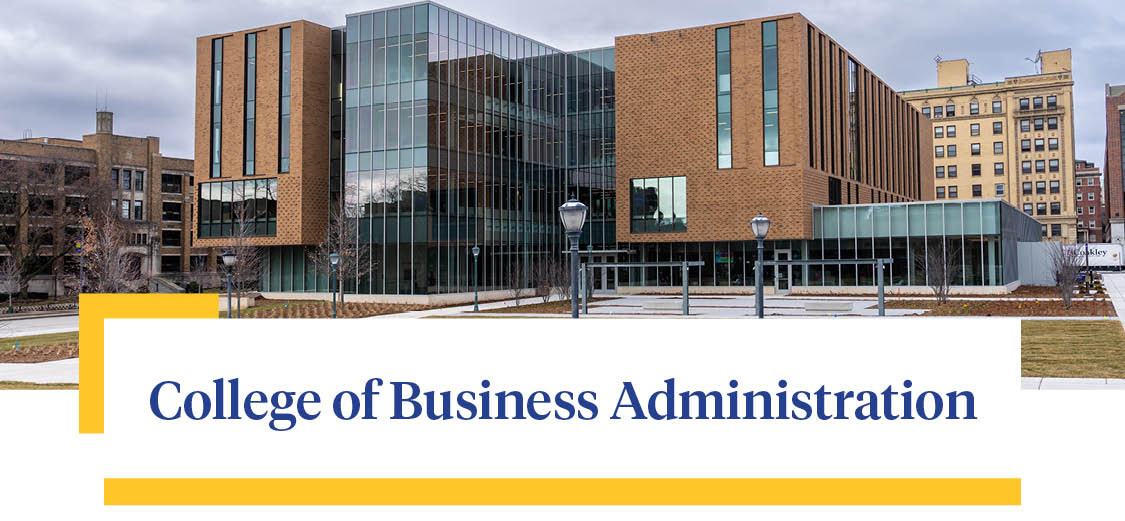
---

## [1. Intro](#intro)


Some machine learning (ML) models for supervised and unsupervised learning are discussed here. Note: general ML workflows and architectures are introduced in [03_R_Intro_BA4.ipynb](https://github.com/LanqingDu/UnstructuredDataAnalytics/blob/main/03_R_Intro_BA4.ipynb). In this notebook, we introduce additional supervised model (logistic regression) for text analysis.


## [2. Objective](#obj)

This tutorial utilizes the dataset available through the [gutenbergr package](https://cran.r-project.org/web/packages/gutenbergr/index.html). In this logistic regression classification task, we aim to use textual features to predict the author of each document.

We begin our introduction to classification starting from train test dat splitting. The following tasks will guide our workflow:

1. **Library Setup**
Install and load all required packages for data access, text processing, train test split, and logistic regression model.

2. **Data Exploration**
Import the dataset and review its structure, variables, and any predefined helper functions.

3. **Text Preprocessing**
Split into training and testing data. Define the response variable and independent variables. Clean and transform the text into a structured format (e.g., data frame or tibble) for classification.

4. **Training a Logistic Regression Model**
In this step, we train a classification model that uses the independent variables as predictors to classify or estimate the categories of the response variable.

5. **Testing a Logistic Regression Model**
Model evaluation is conducted on the testing data using the Receiver Operating Characteristic (ROC) curve and the corresponding Area Under the Curve (AUC) to measure the model’s discriminative ability.








## [3. Data Loading and Partitioning](#pract1)

### 3.1. Load the library and the data

In [1]:
# ========================================================
# Step 1-1: Download and include the data library
# ========================================================

install.packages("gutenbergr")
library(gutenbergr)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
 # ========================================================
# Step 1-2: Download and include the data processing library
# ========================================================

install.packages("tidyverse")
install.packages("tidytext")
install.packages("stopwords")

library(tidyverse)
library(tidytext)
library(stopwords)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
# ========================================================
# Step 1-3: Load in the data (two authors)
# ========================================================


books <- gutenberg_download(gutenberg_id = c(30155, 13476),
                            meta_fields = "author",
                            "http://mirrors.xmission.com/gutenberg/") %>%
         as_tibble() %>%
         mutate(document = row_number()) %>%
         select(-gutenberg_id)

tidy_books <- books %>%
  unnest_tokens(word, text) %>% # Tokenize the text in the text column of the books tibble, breaking it into individual words
  group_by(word) %>%
  filter(n() > 10) %>%
  ungroup()


### 3.2. Train Test Split

In [4]:
# ========================================================
# Step 2: Parition the data into training and testing data
# ========================================================

install.packages("rsample") # provides functions for data splitting, resampling, and related tasks
library(rsample)

#  initial_split(data, prop = 3/4)
#   data          : The data frame or tibble to be split into training and testing subsets.
#   prop          : The proportion of the data to allocate to the training set; here, `3/4` (or 75%) of the data is used for training.
#   Returns       : An `rsplit` object containing information about the training and testing partitions.
#   Output        : Randomly divides the dataset into a training set (75%) and a testing set (25%)
#                   for model development and performance evaluation.

books_split <- books %>%
  select(document) %>%
  initial_split(prop = 3/4) # Split the dataset into 75% for training and 25% for testing.

set.seed(123)
train_data <- training(books_split) # it only returns the index for the document

test_data <- testing(books_split)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### 3.3. Training data (sparse matrix)


Now we want to transform our training data from a tidy data structure to a “sparse matrix” (these objects can be treated as though they were matrices, for example accessing particular rows and columns, but are stored in a more efficient format) to use for our classification algorithm

In [5]:
# ========================================================
# Step 3: Build the sparse matrix for the training data
# ========================================================

#  cast_sparse(row, column, value, shape = NULL)
#   row            : The column to use for the rows of the sparse matrix (e.g., `tidy_boooks`).
#   column         : The column to use for the columns of the sparse matrix (e.g., `document`).
#   value          : The column containing numeric values to fill the cells (e.g., word counts `n`, frequencies, or weights).
#   shape          : (Optional) A two-element vector specifying the number of rows and columns in the matrix;
#                    defaults to dimensions inferred from the data.
#   Returns        : A sparse matrix of class `dgCMatrix` (from the **Matrix** package) with rows and columns defined
#                    by the specified variables.
#   Output         : Produces a document-term matrix (DTM) or term-document matrix (TDM) in sparse format,
#                    efficiently representing text data where most entries are zero.


sparse_words <- tidy_books %>%
  count(document, word) %>%
  inner_join(train_data, by = "document") %>% # filter the word counts to include only the documents in the training set
  cast_sparse(document, word, n) # the cast_sparse() function to convert the filtered word counts into a sparse matrix
                                 # This function takes the document, word, and count columns as arguments
                                 # The result is a sparse matrix where rows represent documents, columns represent unique words,
                                 # and each cell contains the count of that word in the respective document


**``dim(sparse_words)``** When running the ``dim(sparse_words)`` function, the output is 4754 × 893, indicating that the sparse matrix contains 4754 rows and 893 columns.

* 4754 rows → Each row represents a document, text entry, or another unit of analysis, depending on how the document variable was defined in the ``cast_sparse()`` function.

* 893 columns → Each column corresponds to a unique word (term) identified within the corpus.

* In summary, this 4754 × 893 sparse matrix represents a document-term structure, where:

  * Each row is a document.

  * Each column is a distinct word.

  * The cell values indicate the frequency or presence of words within each document.

This structure efficiently captures text data for further analysis while minimizing memory usage by storing only non-zero entries.

**Note**: text feature space handled in this way is very high dimensional, so we need to take that into account when considering our modeling approach.  One reason this overall approach is flexible is that you could at this point ``cbind()`` other columns, such as non-text numeric data, onto this sparse matrix. Then you can use this combination of text and non-text data as your predictors in the classifiaction algorithm, and the regularized regression algorithm we are going to use will find which are important for your problem space

### 3.4. Response variable: the ground truth label representing the author

We also need to build a tibble with a response variable to associate each of the rownames() of the sparse matrix with an author, to use as the quantity we will predict in the model

In [6]:
# ========================================================
# Step 4: Response variable's label (author)
# ========================================================

word_rownames <- as.integer(rownames(sparse_words))

books_joined <- tibble(document = as.integer(rownames(sparse_words))) %>%
                left_join(books %>% select(document, author))

head(books_joined)

Joining with `by = join_by(document)`


document,author
<int>,<chr>
1,"Einstein, Albert"
6,"Einstein, Albert"
8,"Einstein, Albert"
11,"Einstein, Albert"
17,"Einstein, Albert"
18,"Einstein, Albert"


### 3.5 Train a logistic regression model

Now it’s time to train our classification model. Let’s use the ``glmnet`` package to fit a logistic regression model with lasso (least absolute shrinkage and selection operator; also Lasso or LASSO) regularization.

This regression analysis method performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.

``glmnet`` is a package that fits lasso models via penalized maximum likelihood. We do not cover the method and glmnet package in detail at this point, but if you want to learn more about glmnet and lasso regression, review the following resources:.

1. [Introduction to glmnet](https://glmnet.stanford.edu/articles/glmnet.html)
2. [glmnet documentation](https://cran.r-project.org/web/packages/glmnet/glmnet.pdf)
3. [LASSO regression in Python](https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.Lasso.html)

The package is very useful for text classification because the variable selection that lasso regularization performs can tell you which words are important for your prediction problem.

The glmnet package also supports parallel processing, so we can train on multiple cores with cross-validation on the training set using ``cv.glmnet()``.

In [7]:
# ========================================================
# Step 5-1: Fit a regression model for predicting class "Einstein, Albert"
# ========================================================

install.packages("glmnet") # provides functions for fitting L1-regularized logistic regression models
install.packages("doMC") # provides parallelization support

library(glmnet)
library(doMC)

#  registerDoMC(cores)
#   cores          : Integer specifying the number of worker processes (cores) to use.
#                    If omitted, doMC uses:
#                      - options("cores") if set, otherwise
#                      - ~half of the machine’s detected cores (via the parallel package).
#
#   ...            : Package options. Currently only `nocompile` is supported.
#                    Set `nocompile = TRUE` to disable compiler support.
#
#   Platform       : **Unix-only** backend (uses `fork`); not supported on Windows.
#
#   Returns        : Called for side effects (invisibly). After registration, all
#                    `foreach(... ) %dopar% { ... }` calls in the session execute with
#                    the doMC backend. Inspect with:
#                      - `foreach::getDoParName()` / `foreach::getDoParVersion()`
#                      - `foreach::getDoParWorkers()` (number of workers)
#--------------------------------------------------------------------------------
#   cores = 8      : Registers doMC to run `%dopar%` tasks on 8 parallel workers.
#
#   Notes          :
#     - **GUI caution**: Multicore/forked workers should not be used from a GUI
#       environment because multiple processes share the same GUI.
#     - **Scope**: Multicore runs on a single machine (not a cluster).
#     - **When to expect speedups**: Only on hardware with multiple cores and for
#       sufficiently “chunky” tasks; tiny tasks may be slower due to overhead.
#     - **Windows alternative**: Use a socket/cluster backend such as
#       `doParallel::registerDoParallel(makeCluster(n))`.


registerDoMC(cores = 8) # register a parallel backend with 8 cores using doMC that computations will be distributed across the specified number of CPU cores for parallel processing

is_einstein <- books_joined$author == "Einstein, Albert"


#  cv.glmnet(x, y, family = "gaussian", alpha = 1, nfolds = 10, parallel = FALSE, keep = FALSE, ...)
#   x              : The matrix of predictor variables (features). Typically numeric or sparse,
#                    such as a document-term matrix in text classification tasks.
#   y              : The response variable (outcome). Can be continuous (for regression) or categorical/binary
#                    (for classification, e.g., 0/1 labels).
#   family         : Specifies the model type:
#                      - "gaussian"  → Linear regression
#                      - "binomial"  → Logistic regression (binary classification)
#                      - "multinomial" → Multiclass classification
#                      - Other options include "poisson", "cox", etc.
#   alpha          : Controls the type of regularization applied:
#                      - 1 → Lasso regression (L1 penalty)
#                      - 0 → Ridge regression (L2 penalty)
#                      - Between 0 and 1 → Elastic Net (mix of L1 and L2)
#   nfolds         : Number of folds for cross-validation (default = 10).
#   parallel       : Logical; if TRUE, enables parallel processing for faster cross-validation
#                    (requires a parallel backend such as `doParallel`).
#   keep           : Logical; if TRUE, retains fitted models and predictions for each fold during
#                    cross-validation (useful for later inspection).
#   Returns        : A `cv.glmnet` object containing:
#                      - Optimal λ values (`lambda.min` and `lambda.1se`)
#                      - Cross-validation mean squared errors or deviance
#                      - The fitted `glmnet` model for each fold.
#   Output         : Performs k-fold cross-validated regularized regression (Lasso/Ridge/Elastic Net)
#                    and identifies the λ (penalty parameter) that minimizes prediction error.
#                    Commonly used for model tuning and feature selection.


model <- cv.glmnet(sparse_words,  # we use cross-validation here, thus cv.glmnet
                   is_einstein,
                   family = "binomial",
                   parallel = TRUE,
                   keep = TRUE)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-10

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Loading required package: parallel



Let’s use the package ``broom`` (the broom package takes the messy output of built-in functions in R, such as ``lm``, ``nls``, or ``t.test``, and turns them into tidy data frames) to check out the coefficients of the model, for the largest value of lambda with error within 1 standard error of the minimum (``lambda.1se``)

**Note**: The glmnet model object contains the estimated coefficients, where each row represents one coefficient estimate for a specific predictor (textual feature). The ``cv.glmnet()`` function evaluates multiple λ (lambda) values, regularization parameters, during cross-validation to determine the optimal model performance.

Among these, two key λ values are identified:

* ``lambda.min``: the λ that yields the minimum cross-validation error (i.e., the best model performance).

* ``lambda.1se``: the largest λ within one standard error of the minimum, representing a more conservative choice that produces a simpler model with fewer nonzero coefficients while maintaining comparable performance.

* By filtering where ``lambda == model$lambda.1se``, we retain only the coefficients corresponding to this optimal regularization strength, striking a balance between model accuracy and interpretability.

  * Before filtering, we have dim(tidy(model$glmnet.fit)) = 57340 * 5
  * After filtering, we have dim(coefs) = 641 * 5

* These coefficients can later be visualized to display feature importance, to identify which textual predictors contribute most strongly to the model’s classification decisions.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



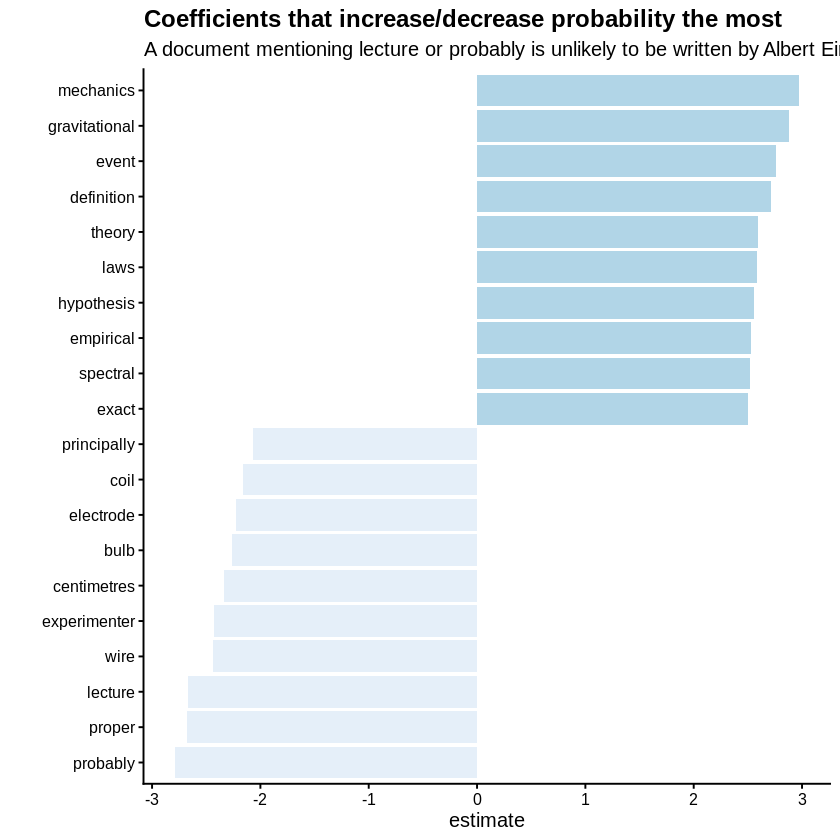

In [8]:
# ========================================================
# Step 5-2: Visualize the important feature for classification
# ========================================================

install.packages("broom") # provides functions for tidying model outputs, such as coefficients

library(broom)

coefs <-  tidy(model$glmnet.fit)  %>%
          filter(lambda == model$lambda.1se) # filters the rows where the lambda value is equal to the optimal lambda determined by cross-validation

coefs %>%
  group_by(estimate > 0) %>% # group the coefficients into two categories based on whether the estimate is greater than 0 (increasing probability) or not
  top_n(10, abs(estimate)) %>% # select the top 10 coefficients with the largest absolute estimates within each group
  ungroup() %>%
  ggplot(aes(fct_reorder(term, estimate), estimate, fill = estimate > 0)) +
  geom_col(alpha = 0.8, show.legend = FALSE) +
  coord_flip() +
  labs(
    x = NULL,
    title = "Coefficients that increase/decrease probability the most",
    subtitle = "A document mentioning lecture or probably is unlikely to be written by Albert Einstein"
  ) +
  theme_classic(base_size = 12) +
  theme(plot.title = element_text(lineheight=.8, face="bold")) +
  scale_fill_brewer()

### 3.6 Prediction on the Test Data

In [9]:
# ========================================================
# Step 6: Get the probability for the specified class on the test data set
# ========================================================

#  pull(.data, var, name = NULL)
#   Function       : Extracts a single column from a data frame or tibble as a
#                    vector. Commonly used at the end of tidyverse pipelines to
#                    convert a tibble column into a simple atomic vector.
#
#   .data          : A data frame or tibble from which the column will be extracted.
#
#   var            : The column to extract.
#                    - Can be specified by name (e.g., estimate) or by position (e.g., 2).
#                    - Quotation marks are optional for syntactic names.
#
#   name           : (Optional) A column whose values will be used to name
#                    elements of the returned vector.
#
#   Returns        : A vector containing the values from the specified column.
#                    The vector inherits the data type of that column
#                    (numeric, character, factor, logical, etc.).
#--------------------------------------------------------------------------------
#   pull(df, estimate)
#
#   Description     : Extracts the column `estimate` from tibble `df` and returns
#                     it as a simple vector (removing tibble structure and metadata).
#                     This is useful for downstream computations that require
#                     vectors, such as modeling functions or summary calculations.
#
#   var = estimate  : Specifies the column to be extracted.
#                     If the data frame `df` has a column named `estimate`,
#                     the command returns a vector of its values.
#
#   name = id       : (Optional) If provided, the resulting vector will use
#                     values from the `id` column as element names.




intercept <- coefs %>%
              filter(term == "(Intercept)") %>%
              pull(estimate)

#  plogis(intercept + score)
#   intercept      : The constant term from the fitted logistic regression model.
#   score          : The linear predictor or model score (sum of weighted feature values).
#   Function       : Applies the logistic (sigmoid) transformation to convert log-odds into probability.
#   Returns        : A numeric value between 0 and 1 representing the predicted probability of the event.
#   Output         : Transforms the linear model output (intercept + score) into a probability scale for interpretation.


# classification results on the test data
classifications <- tidy_books %>%
                    inner_join(test_data) %>%
                    inner_join(coefs, by = c("word" = "term")) %>%
                    group_by(document) %>%
                    summarize(score = sum(estimate)) %>%
                    mutate(probability = plogis(intercept + score))

head(classifications)

Joining with `by = join_by(document)`


document,score,probability
<int>,<dbl>,<dbl>
16,2.160611,0.8992847
28,2.156243,0.8988884
39,5.740848,0.9968885
43,4.352248,0.9876411
46,6.365743,0.9983320
49,3.853407,0.9798086


### 3.7. Model Performance Evaluation

Several model performance metrics could be used, starting from introducing the confusion matrix.


1. **Confusion matrix**. Let’s make the following definitions that “Einstein, Albert” is treated as a positive class and “Tesla, Nikola” is viewed as  a negative class. So we can summarize our “einstein-text-prediction” model using a 2x2 confusion matrix that depicts all four possible outcomes:

    * **True Positive** (TP): The text is actually written by Einstein, and the model correctly predicts it as being from Einstein.

    * **False Positive** (FP): The text is actually written by Tesla, but the model incorrectly predicts it as being from Einstein.

    * **False Negative** (FN): The text is actually written by Einstein, but the model incorrectly predicts it as being from Tesla.

    * **True Negative** (TN): The text is actually written by Tesla, and the model correctly predicts it as being from Tesla.


2. A true positive is an outcome where the model correctly predicts the positive class (Einstein). Similarly, a true negative is an outcome where the model correctly predicts the negative class (Tesla).

3. A false positive is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.

4. Let’s use a probability of **0.5** as our threshold. That means all model predictions with a probability greater than 50% get labeld as beeing text from Einstein.

5. The ``yardstick`` package (yardstick is a package to estimate how well models are working using tidy data principles) is required to calculate some model performance metrics.

In [10]:
# ========================================================
# Step 7-1: yardstick package
# helps with performance measurement and evaluation of models, particularly for supervised learning
# ========================================================

install.packages("yardstick")
library(yardstick)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘yardstick’


The following object is masked from ‘package:readr’:

    spec




In [11]:
# ========================================================
# Step 7-2: Confusion matrix
# ========================================================


comment_classes <- classifications %>%
                    left_join(books %>%
                    select(author, document), by = "document") %>%
                    mutate(author = as.factor(author))

#  conf_mat(truth, estimate)
#   truth          : The column containing the actual (true) class labels (e.g., `author`).
#   estimate       : The column containing the predicted class labels from the model (e.g., `prediction`).
#   Function       : Computes a confusion matrix that cross-tabulates actual vs. predicted classifications.
#   Returns        : A tibble displaying counts of correct and incorrect predictions for each class.
#   Output         : Provides a summary table used to assess classification model performance
#                    (e.g., accuracy, sensitivity, specificity, precision, recall).

# add the prediction label and generate confusion matrix
comment_classes %>%
  mutate(prediction = case_when(probability > 0.5 ~ "Einstein, Albert",
                                TRUE ~ "Tesla, Nikola"),
         prediction = as.factor(prediction)) %>%
         conf_mat(author, prediction)



                  Truth
Prediction         Einstein, Albert Tesla, Nikola
  Einstein, Albert              616            63
  Tesla, Nikola                  76           864

Let’s take a closer look at these misclassifications: false negatives (FN) and false positives (FP)

Which documents here were incorrectly predicted to be written by Albert Einstein, at the extreme probability end of greater than 80% (false positive)?

In [26]:
# ========================================================
# Step 7-3: Classificataion Results - FP
# ========================================================

# filter for False Positives (FP) by selecting documents where the model predicted
# "Tesla, Nikola" with a high probability (> 0.8) but the actual author is "Tesla, Nikola"

FP <- comment_classes %>%
      filter(probability > .8,
              author == "Tesla, Nikola") %>%
      # sample_n(10) %>%
      inner_join(books %>%
      select(document, text)) %>%
      select(probability, text)

dim(FP)
head(FP,n=20)

Joining with `by = join_by(document)`


[1] 5 2

probability,text
<dbl>,<chr>
0.8536408,"during the last three or four hundred years, settling the vast"
0.8296765,shown by the following experiment:
0.8809152,"disc, which could be seen from a considerable distance, such is the"
0.8893255,"there is any motion which is measurable going on in the space, such a"
0.8339580,"velocity--the energy associated with the moving body--is another, and"


These documents were incorrectly predicted to be written by Albert Einstein. However, they were written by Nikola Tesla.

Finally, let’s take a look at the texts which are from Albert Einstein that the model did not correctly identify (false negative):

In [24]:
# ========================================================
# Step 7-4: Classificataion Results - FN
# ========================================================

# filter for False Negatives (FN) by selecting documents where the model predicted "Tesla, Nikola"
# with a low probability (< 0.3) but the actual author is "Einstein, Albert"

FN <- comment_classes %>%
  filter(probability < .3,
         author == "Einstein, Albert") %>%
  # sample_n(10) %>%
  inner_join(books %>%
  select(document, text)) %>%
  select(probability, text)

dim(FN)
head(FN,n=20)

Joining with `by = join_by(document)`


[1] 26  2

probability,text
<dbl>,<chr>
0.24337717,"most intelligible form, and on the whole, in the sequence and"
0.21405198,connection in which they actually originated. In the interest of
0.17104891,wanderer who was unable to see the forest for the trees. May the book
0.02569072,bring some one a few happy hours of suggestive thought!
0.15532942,certainly regard everyone with disdain who should pronounce even the
0.27534487,"London” is a well-defined point, to which a name has been assigned, and"
0.25447712,so easy as it appears at first sight.
0.26528722,and in the direction indicated in Fig 1. People travelling in this
0.25949238,"would reach him simultaneously, _i.e._ they would meet just where he is"


We can conclude that the model did a very good job in predicting the authors of the texts. Furthermore, the texts of the misclassifications are quite short and we can imagine, that even a human reader who is familiar with the work of Einstein and Tesla would have difficulties to classify them correctly

Since the **confusion matrix** depends on the predefined classification threshold, we can instead use the **ROC curve** to evaluate the model’s performance independently of any specific threshold.

**ROC curve:** (receiver operating characteristic curve - a graph showing the performance of a classification model at all classification thresholds) look like:

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


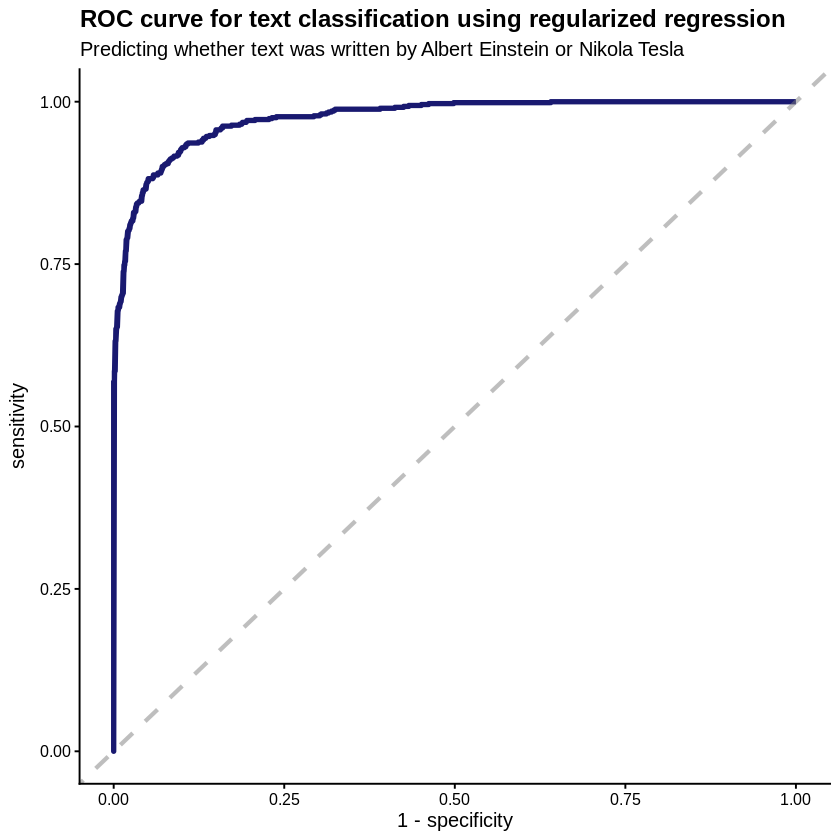

In [27]:
# ========================================================
# Step 8-1: Evluation using ROC
# ========================================================

comment_classes %>% roc_curve(author, probability) %>%
                    ggplot(aes(x = 1 - specificity, y = sensitivity)) +
                        geom_line(
                          color = "midnightblue",
                          size = 1.5 ) +
                        geom_abline(
                          lty = 2, alpha = 0.5,
                          color = "gray50",
                          size = 1.2 ) +
                        labs(
                          title = "ROC curve for text classification using regularized regression",
                          subtitle = "Predicting whether text was written by Albert Einstein or Nikola Tesla" ) +
                        theme_classic(base_size = 12) +
                        theme(plot.title = element_text(lineheight=.8, face="bold"))

Let’s obtain the accuracy (AUC - the fraction of predictions that a classification model got right) on the test data:

In [29]:
# ========================================================
# Step 8-2: AUC
# ========================================================

auc <- comment_classes %>%
  roc_auc(author, probability)

auc

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.9747671
